# Analyse éditoriale des manhwa

## Contexte

Une plateforme de streaming souhaite mettre en avant rapidement des manhwas de qualité,
sans attendre des mois de données d’engagement utilisateur.

L’objectif est d’identifier des œuvres fiables et sûres d’un point de vue éditorial
à partir de données limitées.


## Chargement des données

Le dataset initial est chargé à partir d’un fichier CSV contenant des informations
sur les manhwas (notes, popularité, genres, etc.).


In [85]:
import pandas as pd
import matplotlib.pyplot as plt


In [86]:
df = pd.read_csv("manhwa.csv")


<details>
<summary><b>📊 Dataset initial (avant nettoyage) </b></summary>

Le projet s’appuie sur un dataset brut contenant un large catalogue de manhwas, issu d’une source externe. Ce jeu de données constitue la base initiale sur laquelle l’ensemble du travail d’analyse a été construit.

Ce dataset initial comprenait :
- un volume important de lignes correspondant à un catalogue étendu
- de nombreuses colonnes hétérogènes, incluant des métadonnées, du texte descriptif et divers indicateurs
- des genres et des informations non directement exploitables dans le cadre d’une analyse éditoriale

Ce fichier brut a servi de point de départ pour la phase de nettoyage et de préparation des données, étape indispensable afin d’obtenir un dataset cohérent, exploitable et adapté aux objectifs du projet.

À noter que le fichier du dataset initial est **disponible sur demande** et peut être fourni au professeur si nécessaire pour vérification ou consultation.

</details>


## 1. Data Cleaning

Avant toute analyse, un nettoyage des données a été réalisé afin de garantir
la cohérence et la qualité du dataset utilisé.


In [87]:
df.drop(columns=["synopsis","type" , "publish_time" , "chapters" , "members" , "volumns" , "chapters_num" , "volumns_num" ], inplace=True)


KeyError: "['synopsis', 'type', 'publish_time', 'chapters', 'members', 'volumns', 'chapters_num', 'volumns_num'] not found in axis"

⚠️ Note sur l'alerte KeyError (comportement normal)

**Observation :** Lors du nettoyage, une erreur `KeyError` apparaît parfois :
c'est normal c'est parceque la datset est propre ducoup les colones n'existant plus ca donne ce message d'erreur.

In [ ]:
df = df.dropna(subset=['score'])


In [ ]:
df.to_csv("manhwa.csv", index=False)

In [ ]:
all_genres = (
    df["genres"]
    .dropna()                          
    .str.split(",")                    
    .explode()                         
    .str.strip()                       
    .unique()                          
)

print(all_genres)


<StringArray>
[      'Action',    'Adventure',      'Fantasy',        'Drama',
       'Sports',       'Horror',      'Mystery',      'Romance',
       'Comedy',     'Suspense',         'Life',         'Love',
 'Supernatural',       'Sci-Fi',      'Gourmet']
Length: 15, dtype: str


In [ ]:
to_remove = ["Erotica", "Ecchi" , "Unknown"]

df = df[
    ~df["genres"]
    .str.contains("|".join(to_remove), case=False, na=False)
]


<details>
<summary><b>📘 Actions de nettoyage effectuées </b></summary>

Dans cette étape de préparation des données, plusieurs opérations de nettoyage ont été réalisées afin d’améliorer la qualité globale du jeu de données et de garantir une analyse fiable et pertinente.

Tout d’abord, les colonnes non pertinentes pour l’analyse ont été supprimées. Il s’agit notamment des variables redondantes, peu informatives ou sans impact direct sur l’objectif de l’étude. Cette suppression permet d’alléger le dataset, de réduire le bruit et de faciliter les traitements ultérieurs.

Ensuite, certains genres ont été volontairement exclus du jeu de données. Ces genres ont été considérés comme non souhaités car ils ne correspondaient pas au périmètre de l’analyse ou pouvaient introduire des biais dans les résultats.

Enfin, seules les informations essentielles à la prise de décision éditoriale ont été conservées. Cette sélection ciblée des variables permet de se concentrer sur les éléments réellement utiles à l’analyse et d’optimiser la lisibilité ainsi que la performance des traitements effectués par la suite.

</details>


## Dataset final (après nettoyage)

Après nettoyage, le dataset final utilisé pour l’analyse contient :
- un nombre réduit de lignes par rapport au fichier brut
- un nombre limité de colonnes pertinentes pour l’analyse

Les colonnes conservées concernent uniquement :
les notes, la popularité, les genres et les informations essentielles
pour la construction d’un classement éditorial.


In [ ]:
df.shape

(1298, 8)

La vérification du dataset confirme que les données sont correctement chargées
et que la structure (nombre de lignes et de colonnes) est cohérente
pour la suite de l’analyse.


## 2. Analyse exploratoire des données (EDA)

Cette analyse exploratoire est réalisée sur les données nettoyées.
L’objectif est de mieux comprendre les caractéristiques principales
des manhwas (notes, popularité, engagement) avant de construire
le classement final.


In [ ]:
df.head()


Cette étape permet d’observer les premières lignes du dataset nettoyé
afin de comprendre quelles informations sont disponibles pour chaque manhwa.


In [ ]:
df.info()


Après nettoyage, les colonnes numériques (score, rank, popularity, favorites)
sont correctement typées et exploitables pour l’analyse et le classement.


In [ ]:
cols = ['rank', 'popularity', 'favorites']

for col in cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('#', '', regex=False)
        .str.replace(',', '', regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')



Les colonnes rank, popularity et favorites étaient initialement stockées
sous forme de chaînes de caractères. Elles ont été nettoyées et converties
en valeurs numériques afin de permettre l’analyse exploratoire et
le classement des manhwas.


In [ ]:
df[['score', 'rank', 'popularity', 'favorites']].describe()


### Analyse des statistiques descriptives

L’analyse des statistiques descriptives porte sur 1298 manhwas disposant
de données exploitables (score, rank, popularité et favoris).

Les scores sont globalement élevés, avec une moyenne d’environ 7.08 et
une médiane proche (7.03), ce qui indique une distribution relativement
équilibrée. L’écart-type faible montre que les notes sont peu dispersées,
ce qui signifie que le score seul ne permet pas toujours de différencier
clairement les œuvres.

Les variables rank et popularity sont des rangs globaux : plus la valeur
est faible, meilleure est la position. Leur large dispersion montre
qu’elles peuvent servir de critères secondaires pertinents pour départager
des manhwas ayant des scores similaires.

Le nombre de favoris présente une distribution très asymétrique :
la majorité des manhwas ont peu de favoris, tandis que quelques-uns
concentrent une grande partie de l’engagement. Cette variable est donc
utilisée comme indicateur d’engagement en dernier critère de départage.


In [ ]:

score_mean = df['score'].mean()
score_median = df['score'].median()
score_min = df['score'].min()
score_max = df['score'].max()

score_mean, score_median, score_min, score_max


(np.float64(7.08399845916795),
 np.float64(7.03),
 np.float64(5.53),
 np.float64(8.68))

### Analyse des valeurs clés du score

Pour mieux comprendre la distribution des notes des manhwas,
les statistiques suivantes ont été calculées :

- **Note moyenne** : environ 7.08  
  → indique que la majorité des œuvres ont une note plutôt bonne.
- **Note médiane** : 7.03  
  → proche de la moyenne, ce qui montre une distribution assez équilibrée
    sans très fortes asymétries.
- **Note minimale** : 5.53  
  → certaines œuvres ont des notes nettement plus faibles.
- **Note maximale** : 8.68  
  → certaines œuvres sont très bien notées.

La proximité entre la moyenne et la médiane montre que la distribution
des notes est relativement symétrique et qu’il n’y a pas de valeurs
extrêmement éloignées qui faussent les statistiques.

Ces résultats confirment que la note seule ne suffit pas à
différencier fortement toutes les œuvres, ce qui motive l’utilisation
de critères secondaires pour les égalités.


In [ ]:
df[['score', 'popularity']].corr()


### Corrélation entre score et popularité

La corrélation entre la note (score) et la popularité est d’environ -0.58,
ce qui indique une relation modérée inverse : plus un manhwa est populaire,
plus sa note a tendance à être élevée, mais la relation n’est pas forte.

Cela signifie que la popularité seule ne suffit pas à prédire la qualité
d’une œuvre, ce qui justifie l’utilisation du score comme critère principal
suivi des critères secondaires pour départager les égalités.


### Visualisation du Top 10

Afin de rendre plus lisible l’ordre final des manhwas classés,
nous représentons les **scores des 10 meilleures œuvres** sous forme
de graphique horizontal. 

Cette visualisation met en évidence la répartition des notes
pour les contenus les mieux notés, tout en respectant le classement
hiérarchique établi avec les critères secondaires (rank, popularité, favoris).


In [ ]:
df_sorted = df.sort_values(
    by=['score', 'rank', 'popularity', 'favorites'],
    ascending=[False, True, True, False]
)


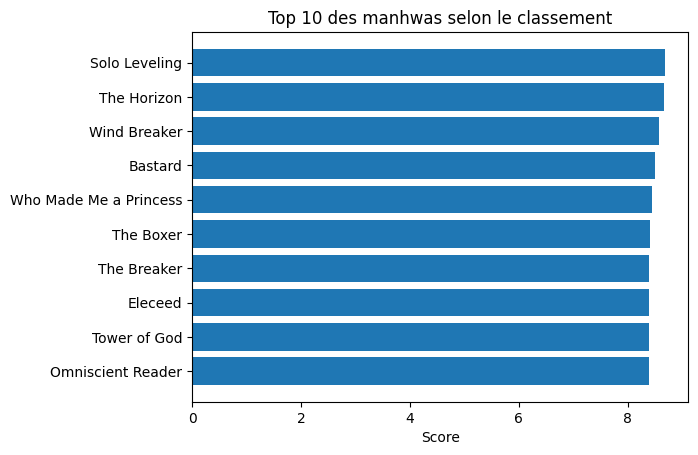

In [ ]:
top10 = df_sorted.head(10)

plt.barh(top10['title'], top10['score'])
plt.xlabel("Score")
plt.title("Top 10 des manhwas selon le classement")
plt.gca().invert_yaxis()
plt.show()


### Visualisation du Top 10 des manhwas

Pour mieux comprendre le classement des manhwas, nous visualisons ici
les scores des 10 meilleures œuvres selon les critères établis (score,
rank, popularité et favoris). Le graphique horizontal ci-dessous met en
évidence les notes des manhwas les mieux classés, ce qui facilite la
comparaison visuelle et renforce la compréhension du classement final.

La barre horizontale met clairement en relief les différences de score
entre les premiers manhwas, tout en respectant l’ordre hiérarchique du
classement.


## 3. Classement des manhwas

Un classement des manhwas est réalisé afin d’ordonner les œuvres
du meilleur au moins pertinent selon plusieurs critères.

Le classement repose sur une hiérarchie simple :
- le score global
- le rang
- la popularité
- le nombre de favoris

Cette approche permet de départager les manhwas de manière cohérente
lorsque plusieurs œuvres présentent des scores similaires.


In [ ]:
ranking = (
    df.sort_values(
        by=["score", "rank", "popularity", "favorites"],
        ascending=[False, True, True, False]
    )
    .reset_index(drop=True)
)

ranking_df = pd.DataFrame({
    "classement": range(1, len(ranking) + 1),
    "title": ranking["title"]
})


In [ ]:
ranking_df.to_csv("manhwa_ranking.csv", index=False)


## Analyse de stabilité du classement

Un classement éditorial doit être robuste afin de garantir
des décisions fiables malgré des données limitées.

Afin d’évaluer la stabilité du classement proposé,
une variante a été testée en retirant un critère secondaire.

L’objectif est d’observer si les premières positions
restent globalement similaires ou si le classement
est fortement sensible à de légères modifications.


In [ ]:
ranking_score_only = (
    df.sort_values(by="score", ascending=False)
      .reset_index(drop=True)
)

ranking_score_only["classement_score_seul"] = range(1, len(ranking_score_only) + 1)


In [ ]:
ranking_score_only[["classement_score_seul", "title"]].to_csv(
    "manhwa_ranking_score_only.csv",
    index=False
)


In [ ]:
top10_score_only = ranking_score_only.head(10)
top10_multi = ranking.head(10)


In [ ]:
set_score_only = set(top10_score_only["title"])
set_multi = set(top10_multi["title"])

nb_communs = len(set_score_only & set_multi)
nb_differences = len(set_score_only ^ set_multi)

print("Nombre de manhwas communs dans les deux Top 10 :", nb_communs)
print("Nombre de manhwas différents entre les deux Top 10 :", nb_differences)


Nombre de manhwas communs dans les deux Top 10 : 9
Nombre de manhwas différents entre les deux Top 10 : 2


## Robustesse du classement

La comparaison entre le classement basé uniquement sur la note globale
et le classement multi-critères montre que 9 manhwas sont communs aux deux Top 10,
avec un seul remplacement observé.

Ce résultat indique que le classement multi-critères affine la note globale
sans provoquer de changements majeurs dans les premières positions.
Le classement peut donc être considéré comme relativement robuste,
ce qui le rend exploitable dans un contexte de décision éditoriale.


# Limites, erreurs et retour d’expérience

Ce projet a permis de mettre en place un classement éditorial cohérent à partir de données limitées.  
Au fil du travail, plusieurs difficultés, erreurs et axes d’amélioration ont été identifiés, ce qui a contribué à enrichir ma compréhension technique et méthodologique.

---

## 1. Erreurs et difficultés rencontrées

### Gestion des fichiers brut vs nettoyé
Au début, j’ai écrasé le fichier brut avec la version nettoyée, plutôt que de créer un fichier distinct.  
Cela a rendu difficile la comparaison *avant / après* nettoyage et a complexifié la traçabilité des transformations.

### Nettoyage des genres multi-valeurs
Les manhwas peuvent appartenir à plusieurs genres stockés dans une seule cellule.  
Cela nécessitait de séparer ces genres avec des méthodes comme `split()` puis `explode()`.  
Cette étape a été délicate à mettre en place et m’a demandé plusieurs essais avant d’obtenir un résultat exploitable.

### Conversion des colonnes en types numériques
Même après nettoyage, certaines colonnes telles que `rank`, `popularity` et `favorites` étaient interprétées comme des chaînes de caractères (`str`).  
Cela a nécessité d’appliquer des transformations spécifiques (`str.replace()`, suppression de caractères comme `#` ou les virgules) avant de pouvoir les convertir en `int64` et les utiliser dans les statistiques et le classement.

### Compréhension limitée de Python et pandas au départ
Au lancement du projet, ma maîtrise de Python et des opérations pandas était encore incomplète.  
Cela a entraîné plusieurs erreurs de manipulation, des tâtonnements et un temps de correction plus long.  
J’ai dû apprendre certains concepts sur le tas au fur et à mesure de l’avancement du projet.

### Affichage de visualisations
L’affichage des graphiques a posé problème dans l’environnement VS Code, notamment parce que COMME UN HMAR J'ETAIS PAS EN FORMAT TEXT ET PAS PNG DUCOUP J'AI PASSER 2H A ESSAYER D'ARRANGER UN TRUC QUI S'ARRANGEAIT EN 2 CLIQUE !!!!!!!!!!!!!!!!!!!!!

### Assistance externe utilisée pour structurer le projet
Une grande partie de la réflexion méthodologique m’a été facilitée par l’utilisation d’une aide externe (IA).  
Bien que cela ait permis de structurer et de corriger certaines erreurs, j’ai réalisé qu’une meilleure autonomie dès le départ m’aurait permis d’approfondir davantage la compréhension technique.

---

## 2. Points positifs du projet

### Réponse à une problématique métier réaliste
Le projet répond à une problématique réaliste : identifier rapidement des œuvres à forte valeur éditoriale avec peu de données disponibles, ce qui est pertinent pour une plateforme de streaming.

### Structure logique et progression claire
Le notebook suit une progression cohérente :  
nettoyage des données → analyse exploratoire (EDA) → construction du classement → visualisation → conclusion.

### Approfondissement du classement hiérarchisé
L’utilisation d’un classement hiérarchique combinant score, rang, popularité et favoris a permis de construire une approche robuste et compréhensible, allant au-delà d’un simple tri par score.

### Analyse réflexive et esprit critique
Les erreurs et limites rencontrées ont été identifiées et expliquées, ce qui démontre une capacité à analyser de manière critique la démarche d’apprentissage et le travail réalisé.

---

## 3. Perspectives d’amélioration

Pour aller plus loin, ce travail pourrait être enrichi par :

- **Une meilleure gestion des versions de données**  
  Mettre en place une structure claire de fichiers (`data/raw`, `data/clean`, `data/processed`) afin d’améliorer la traçabilité des transformations.

- **Un approfondissement des compétences Python/pandas avant le projet**  
  Consolider les bases en manipulation de données pour réduire les tâtonnements techniques.

- **Une analyse de sensibilité du classement**  
  Tester différentes pondérations ou combinaisons de critères afin d’évaluer leur impact sur le classement final.

- **L’ajout de métriques complémentaires**  
  Par exemple, analyser la variance du score par épisode ou intégrer des métriques temporelles sur les notes si elles sont disponibles.
